# DENOISING AUTOENCODER FOR MIDI

run tensorboard with `tensorboard --logdir=runs --bind_all`

## Load Libraries

In [1]:
# torch loaded...!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision loaded...!!!
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard.writer import SummaryWriter
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchinfo import summary

# matplotlib loaded...!!!
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from tqdm.notebook import tqdm

### Dark Theme

In [2]:
plt.style.use("dark_background")

In [5]:
%%html
<style>
    .cell-output-ipywidget-background {
        background-color: transparent !important;
    }

    :root {
        --jp-widgets-color: var(--vscode-editor-foreground);
        --jp-widgets-font-size: var(--vscode-editor-font-size);
    }
</style>

## Define Constants

In [6]:
# Constants
TESTING = False
NUM_EPOCHS = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NOISE_FACTOR = 0.01  # constant NOISE_FACTOR which defines the amount of noise that we will add to our images.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Prepare the Data

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]
)

## Data Loader and Download

### Custom Dataset

In [9]:
class MIDILoopDataset(Dataset):
    def __init__(
        self,
        data,
        transforms=None,
    ):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name, image = self.data[idx]
        image = self.format_image(image)
        if self.transforms:
            image = self.transforms(image)
        return name, image

    def format_image(self, image, remove_time=True):
        if remove_time:
            image = np.delete(image, 0, axis=1)
        image = torch.from_numpy(np.expand_dims(image, 0)).to(torch.float32)
        if torch.any(image > 1.0):
            image = image / image.max()
        image = F.pad(input=image, pad=(0, 12, 1, 1), mode="constant", value=0.0)

        return image

In [10]:
input_dataset = np.load("data/all_loops.npz")
inputDataset = MIDILoopDataset(list(input_dataset.items()))
train_set, test_set = random_split(inputDataset, [0.8, 0.2])

trainLoader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testLoader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [11]:
if TESTING:
    # Download the FashionMNIST dataset
    trainset = torchvision.datasets.FashionMNIST(
        root="./data_new", train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.FashionMNIST(
        root="./data_new", train=False, download=True, transform=transform
    )

    # Load the dataset in the dataloader
    trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testLoader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
for batch in trainLoader:
    batch1 = batch
    break

if TESTING:
    print(batch1[0].shape)
else:
    print(batch1[1].shape)

torch.Size([32, 1, 60, 412])


## Utilities

In [13]:
def make_dir():
    image_dir = "Saved_Images"
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)

In [14]:
def save_decoded_image(img, name):
    if TESTING:
        img = img.view(img.size(0), 1, 28, 28)
    else:
        img = img.view(img.size(0), 1, 60, 412)

    save_image(img, "Saved_Images/" + name + ".png")

In [15]:
def plot_images(images, titles, set_axis="off"):
    num_images = len(images)
    for num_plot in range(num_images):
        plt.subplot(num_images, 1, num_plot + 1)
        plt.imshow(
            np.squeeze(images[num_plot]),
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        plt.title(titles[num_plot])
        plt.axis(set_axis)

    plt.show()

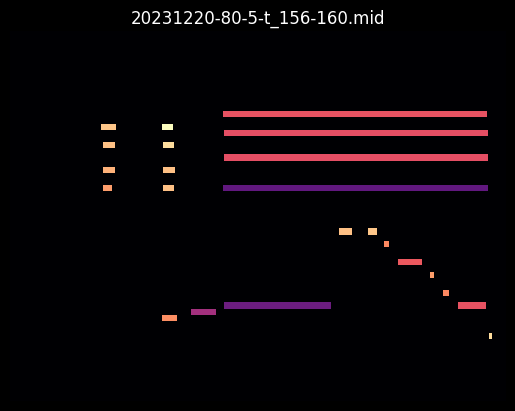

In [16]:
if TESTING:
    plot = plot_images([np.squeeze(batch1[0][0])], ["test"])
else:
    plot = plot_images([batch1[1][0]], [batch1[0][0]])

## Define the Model

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.pool(F.relu(self.enc1(x)))
        x = self.pool(F.relu(self.enc2(x)))
        x = self.pool(F.relu(self.enc3(x)))
        x = self.pool(F.relu(self.enc4(x)))  # latent space representation

        # Decoder
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))

        return x


model = AutoEncoder().to(device)

In [18]:
print(model)

AutoEncoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [19]:
if TESTING:
    print(summary(model, (1, 28, 28)))
else:
    print(summary(model, (1, 58, 400)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 60, 412]              --
├─Conv2d: 1-1                            [64, 58, 400]             640
├─MaxPool2d: 1-2                         [64, 29, 200]             --
├─Conv2d: 1-3                            [32, 29, 200]             18,464
├─MaxPool2d: 1-4                         [32, 14, 100]             --
├─Conv2d: 1-5                            [16, 14, 100]             4,624
├─MaxPool2d: 1-6                         [16, 7, 50]               --
├─Conv2d: 1-7                            [8, 7, 50]                1,160
├─MaxPool2d: 1-8                         [8, 3, 25]                --
├─ConvTranspose2d: 1-9                   [8, 7, 51]                584
├─ConvTranspose2d: 1-10                  [16, 15, 103]             1,168
├─ConvTranspose2d: 1-11                  [32, 30, 206]             2,080
├─ConvTranspose2d: 1-12                  [64, 60, 412]             

## Optimizer and Loss Function

In [20]:
# the loss function
loss_fn = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Defining the training and test function

In [21]:
def train(net, trainLoader, NUM_EPOCHS, logging=True):
    train_loss = []
    if logging:
        writer = SummaryWriter(
            f"runs/{datetime.now().strftime('%y-%m-%d_%H%M%S')}_rebuild"
        )
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        with tqdm(trainLoader, unit="batch") as tepoch:
            for i, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}")
                name, img = data
                if TESTING:
                    img, _ = data  # we do not need the image labels
                # add noise to the image data
                img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0.0, 1.0)
                img_noisy = img_noisy.to(device)
                optimizer.zero_grad()
                outputs = net(img_noisy)
                loss = loss_fn(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

                if logging:
                    global_step = epoch * len(trainLoader) + i
                    writer.add_scalar("training/loss", loss.item(), global_step)
                    for p_name, param in model.named_parameters():
                        writer.add_histogram(
                            f"weights/{p_name}", param.data, global_step
                        )
                        if param.requires_grad:
                            writer.add_histogram(
                                f"gradients/{p_name}.grad", param.grad, global_step
                            )

            loss = running_loss / len(trainLoader)
            train_loss.append(loss)
            save_decoded_image(img_noisy.cpu().data, name="noisy{}".format(epoch))
            save_decoded_image(outputs.cpu().data, name="denoised{}".format(epoch))

    return train_loss

## Model Training and Result Analysis

In [22]:
train_loss = train(model, trainLoader, NUM_EPOCHS, logging=True)

  0%|          | 0/36 [00:00<?, ?batch/s]

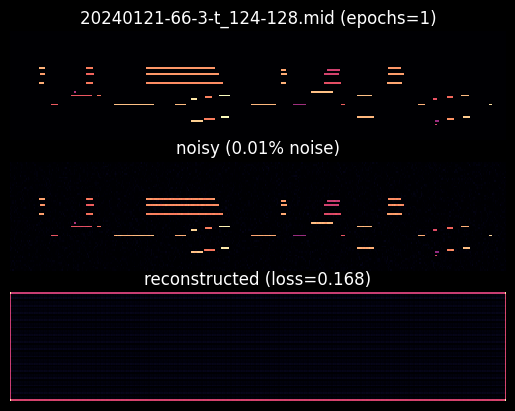

In [30]:
def test_image_reconstruction(net, testloader):
    for batch in testloader:
        name, img = batch
        if TESTING:
            img = name[0]

        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0.0, 1.0)
        img_noisy = img_noisy.to(device)
        outputs = net(img_noisy)
        outputs = outputs.cpu().data

        images = [
            img if TESTING else inputDataset.format_image(input_dataset[name[0]]),
            img_noisy[0].cpu().data,
            outputs[0],
        ]
        titles = [
            f"{'original' if TESTING else name[0]} (epochs={NUM_EPOCHS})",
            f"noisy ({NOISE_FACTOR}% noise)",
            f"reconstructed (loss={train_loss[0]:.03f})",
        ]

        plot_images(images, titles)
        break


test_image_reconstruction(model, testLoader)

###

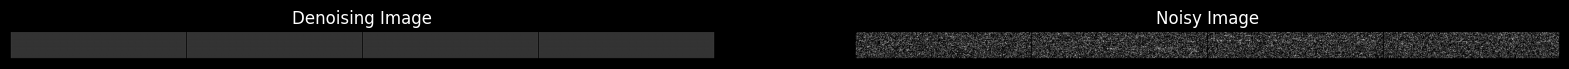

In [ ]:
import matplotlib.image as mpimg

plt.figure(figsize=(20, 20))
img = mpimg.imread("Saved_Images/denoised9.png")
img1 = mpimg.imread("Saved_Images/noisy9.png")
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Denoising Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img1)
plt.title("Noisy Image")
plt.axis("off")
plt.show()